# Multivariate Time-Series Forecasting: Predict Iron Prices

In [1]:
n_future= 3 # number of moths to be predicted
n_past= 24 # the size of the windowed dataframe

### Import libs

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
from pylab import rcParams


from sklearn.preprocessing import StandardScaler

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam


In [3]:
# Create date column for both dataframes:
# this function takes a string object which is in a date format and covert it to a date object
def str_to_datetime(s):
  split = s.split('/')
  month, day, year = int(split[0]), int(split[1]), int(split[2])
  return dt.datetime(year=year, month=month, day=day)

## Part 1: Data preprocessing

###  Read and load the data; we want to select the features for the training and prediction and extract the date column then make it the index

Index & Date columns...

In [15]:
df_fed_fund= pd.read_csv(r'C:\Users\fnafisa\WORKSPACE\Project PoC\Input\data\Fed fund rates\FEDFUNDS.csv')
df_fed_fund

,DATE,FEDFUNDS
0,1954-07-01,0.80
1,1954-08-01,1.22
2,1954-09-01,1.07
3,1954-10-01,0.85
4,1954-11-01,0.83
...,...,...
815,2022-06-01,1.21
816,2022-07-01,1.68
817,2022-08-01,2.33
818,2022-09-01,2.56


In [19]:
df_fed_fund['DATE']= df_fed_fund['DATE'].str.replace('-','/')
df_fed_fund

,DATE,FEDFUNDS
0,1954/07/01,0.80
1,1954/08/01,1.22
2,1954/09/01,1.07
3,1954/10/01,0.85
4,1954/11/01,0.83
...,...,...
815,2022/06/01,1.21
816,2022/07/01,1.68
817,2022/08/01,2.33
818,2022/09/01,2.56


In [16]:
df_TASI= pd.read_csv(r'C:\Users\fnafisa\WORKSPACE\Project PoC\Input\data\Markets\Tadawul All Share Historical Data monthly.csv')
df_TASI

,Date,Price,Open,High,Low,Vol.,Change %
0,11/01/2022,"11,598.76","11,678.80","11,679.41","11,333.45",138.93M,-0.59%
1,10/01/2022,"11,667.80","11,420.66","12,099.60","11,325.68",3.16B,2.30%
2,09/01/2022,"11,405.32","12,253.13","12,283.70","10,909.18",2.75B,-7.15%
3,08/01/2022,"12,283.33","12,236.73","12,714.56","12,197.35",4.02B,0.69%
4,07/01/2022,"12,199.08","11,590.31","12,268.51","11,096.74",2.76B,5.86%
...,...,...,...,...,...,...,...
114,05/01/2013,"7,404.12","7,179.80","7,419.94","7,085.31",4.28B,3.12%
115,04/01/2013,"7,179.80","7,125.73","7,248.18","7,028.39",4.55B,0.76%
116,03/01/2013,"7,125.73","6,998.33","7,190.40","6,927.23",3.25B,1.82%
117,02/01/2013,"6,998.33","7,043.55","7,094.37","6,955.33",3.44B,-0.64%


In [1]:
# read the data and convert index to date:

#            iron_12mm
df_iron_12mm= pd.read_excel(r'C:\Users\fnafisa\WORKSPACE\Project PoC\Input\data\iron ore\price 12mm iron.xlsx')
# create column to concatenate the day, month and year
df_iron_12mm['date'] = df_iron_12mm['month'].map(str)+ '/'  + '1' + '/' + df_iron_12mm['year'].map(str)
# apply the function str_to_datetime on df_iron_12mm & assign date to be the new indexes
df_iron_12mm['date'] = df_iron_12mm['date'].apply(str_to_datetime)
df_iron_12mm.index = df_iron_12mm.pop('date')
# we keep only the needed columns
df_iron_12mm= pd.DataFrame(df_iron_12mm['price'])
df_iron_12mm.columns= ['iron_12mm']

#           iron_10mm
df_iron_10mm= pd.read_excel(r'C:\Users\fnafisa\WORKSPACE\Project PoC\Input\data\iron ore\price 10mm iron.xlsx')
# create column to concatenate the day, month and year
df_iron_10mm['date'] = df_iron_10mm['month'].map(str)+ '/'  + '1' + '/' + df_iron_10mm['year'].map(str)
# apply the function str_to_datetime on df_iron_10mm & assign date to be the new indexes
df_iron_10mm['date'] = df_iron_10mm['date'].apply(str_to_datetime)
df_iron_10mm.index = df_iron_10mm.pop('date')
# we keep only the needed columns
df_iron_10mm= pd.DataFrame(df_iron_10mm['price'])
df_iron_10mm.columns= ['iron_10mm']

#           oil
df_oil_brent= pd.read_csv(r'C:\Users\fnafisa\WORKSPACE\Project PoC\Input\data\Oil\Brent Oil Futures Historical Data; monthly.csv')
df_oil_brent['Date'] = df_oil_brent['Date'].apply(str_to_datetime)
df_oil_brent.index = df_oil_brent.pop('Date')
# we keep only the needed columns
df_oil_brent= pd.DataFrame(df_oil_brent['Price'])
df_oil_brent.columns= ['oil_brent']

#           TASI
df_TASI= pd.read_csv(r'C:\Users\fnafisa\WORKSPACE\Project PoC\Input\data\Markets\Tadawul All Share Historical Data monthly.csv')
df_TASI['Date'] = df_TASI['Date'].apply(str_to_datetime)
df_TASI.index = df_TASI.pop('Date')
# we keep only the needed columns
df_TASI= pd.DataFrame(df_TASI['Price'])
df_TASI.columns= ['tasi']

#           gold
df_gold= pd.read_csv(r'C:\Users\fnafisa\WORKSPACE\Project PoC\Input\data\gold\Gold Futures Historical Data monthly.csv')
df_gold['Date'] = df_gold['Date'].apply(str_to_datetime)
df_gold.index = df_gold.pop('Date')
# we keep only the needed columns
df_gold= pd.DataFrame(df_gold['Price'])
df_gold.columns= ['gold']


#           fed fund
df_fed_fund= pd.read_csv(r'C:\Users\fnafisa\WORKSPACE\Project PoC\Input\data\Fed fund rates\FEDFUNDS.csv')
df_fed_fund['Date'] = df_fed_fund['DATE'].apply(str_to_datetime)
df_fed_fund.index = df_fed_fund.pop('Date')
# we keep only the needed columns
df_fed_fund= pd.DataFrame(df_fed_fund['FEDFUNDS'])
df_fed_fund.columns= ['fedFund']

NameError: name 'pd' is not defined

  ----->>> JOIN <<<-----

In [5]:
# join the two dataframes based on date index to create the traing dataset
# dataset_train = pd.merge(df_iron_12mm,df_iron_10mm, how='left', left_index=True, right_index=True)
dataset_train = pd.merge(df_iron_12mm,df_oil_brent, how='left', left_index=True, right_index=True)
dataset_train = pd.merge(dataset_train,df_TASI, how='left', left_index=True, right_index=True)
dataset_train = pd.merge(dataset_train,df_gold, how='left', left_index=True, right_index=True)



In [6]:
dataset_train['hist_1']= dataset_train['iron_12mm'].shift(1)

dataset_train['hist_1'].fillna(value=dataset_train['hist_1'].mean(), inplace=True)

dataset_train

,iron_12mm,oil_brent,tasi,gold,lag_1
date,,,,,
2013-01-01,2964.917,114.54,"7,043.55","1,662.00",2615.09244
2013-02-01,2964.750,110.42,"6,998.33","1,578.90",2964.91700
2013-03-01,2964.942,109.79,"7,125.73","1,595.70",2964.75000
2013-04-01,2964.917,102.04,"7,179.80","1,472.70",2964.94200
2013-05-01,2964.917,100.20,"7,404.12","1,393.00",2964.91700
...,...,...,...,...,...
2022-05-01,4000.960,115.60,"12,921.74","1,848.40",4032.60000
2022-06-01,3704.880,109.03,"11,523.25","1,812.00",4000.96000
2022-07-01,3595.940,103.97,"12,199.08","1,771.50",3704.88000


check for null values:

In [7]:
dataset_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 117 entries, 2013-01-01 to 2022-09-01
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   iron_12mm  117 non-null    float64
 1   oil_brent  117 non-null    float64
 2   tasi       117 non-null    object 
 3   gold       117 non-null    object 
 4   lag_1      117 non-null    float64
dtypes: float64(3), object(2)
memory usage: 9.6+ KB


In [8]:
# select features (columns) to be involved into training and predictions
cols= list(dataset_train)[:]
# make the dataframe on a monthly basis
dataset_train= dataset_train.to_period(freq='m')

# EXTRACT dates:
# store the date index in a list 
datelist_train= dataset_train.index.strftime('%Y-%m')
datelist_train= [dt.datetime.strptime(date, '%Y-%m').date() for date in datelist_train]



In [9]:
print('Training set shape == {}'.format(dataset_train.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(cols))
print('Sample of date list: {}...{}'.format(datelist_train[0:2], datelist_train[-3:-1]))

Training set shape == (117, 5)
All timestamps == 117
Featured selected: ['iron_12mm', 'oil_brent', 'tasi', 'gold', 'lag_1']
Sample of date list: [datetime.date(2013, 1, 1), datetime.date(2013, 2, 1)]...[datetime.date(2022, 7, 1), datetime.date(2022, 8, 1)]


###  Shaping and transformation

In [10]:
# make sure there are no commas in any number
dataset_train= dataset_train[cols].astype(str)
for i in cols:
    for j in range(0, len(dataset_train)):
        dataset_train[i][j]= dataset_train[i][j].replace(',','')
dataset_train= dataset_train[cols].astype(float)

# Using multiple predictors (features)
# we need convert (reshape) to a matrix(array) using .to_numpy
training_set= dataset_train.to_numpy()
print('Shape of training set == {}.'.format(training_set.shape))

Shape of training set == (117, 5).


In [11]:
len(training_set[:,0])

117

In [12]:
# Feature scaling hence features vary in range
sc= StandardScaler()
sc_predict= StandardScaler()

training_set_scaled= sc.fit_transform(training_set)
sc_predict.fit_transform(training_set[:,0:1]) # our target (iron_12mm) / the dependant variable
print('')


## Part 2: Modeling

###  Build the model architecture and Set up the WINDOWED DATAFRAME 

In [70]:
# Create a data structure with timestamps
X_train= []
y_train= []
n_future= 6 # number of moths to be predicted
n_past= 24 # the size of the windowed dataframe

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1] - 1])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))
model= Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(n_past, dataset_train.shape[1]-1)))
model.add(Dropout(.25))
model.add(LSTM(units=10, return_sequences=False))
model.add(Dropout(.25))
model.add(Dense(units=1, activation='linear'))
model.compile(optimizer= Adam(learning_rate=.006), loss= 'mean_squared_error')

X_train shape == (88, 24, 4).
y_train shape == (88, 1).


In [71]:
%%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=20, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train, y_train, shuffle=True, epochs=50, callbacks=[es, rlr, mcp, tb], validation_split=0.3, verbose=1, batch_size=32)

Epoch 1/50
1/2 [==============>...............] - ETA: 2s - loss: 0.5048
Epoch 1: val_loss improved from inf to 1.42833, saving model to weights.h5
2/2 [==============================] - 3s 643ms/step - loss: 0.3538 - val_loss: 1.4283 - lr: 0.0060
Epoch 2/50
1/2 [==============>...............] - ETA: 0s - loss: 0.1912
Epoch 2: val_loss improved from 1.42833 to 1.14502, saving model to weights.h5
2/2 [==============================] - 0s 60ms/step - loss: 0.1820 - val_loss: 1.1450 - lr: 0.0060
Epoch 3/50
1/2 [==============>...............] - ETA: 0s - loss: 0.1067
Epoch 3: val_loss improved from 1.14502 to 1.13507, saving model to weights.h5
2/2 [==============================] - 0s 62ms/step - loss: 0.1779 - val_loss: 1.1351 - lr: 0.0060
Epoch 4/50
1/2 [==============>...............] - ETA: 0s - loss: 0.1857
Epoch 4: val_loss did not improve from 1.13507
2/2 [==============================] - 0s 55ms/step - loss: 0.1391 - val_loss: 1.1384 - lr: 0.0060
Epoch 5/50
1/2 [==============>

###  training and testing

## Part 3: Forcasting

In [72]:
# Generate list of sequence of months for predictions w datetime type
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1m').tolist()
datelist_future_= []
for d in datelist_future:
    d= d + dt.timedelta(days=1)
    d= d.date()
    datelist_future_.append(d)
# (datelist_future_)

# Perform predictions
predictions_future = model.predict(X_train[-n_future:])

predictions_train = model.predict(X_train[n_past:])

2/2 [==============================] - 0s 5ms/step


### Step 5: Predict the future

In [73]:
# Perform predictions
predictions_future = model.predict(X_train[-n_future:])

predictions_train = model.predict(X_train[n_past:])

def datetime_to_timestamp(x):
    '''
        x : a given datetime value (datetime.date)
    '''
    return dt.strptime(x.strftime('%Y%m%d'), '%Y%m%d')


y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['predicted']).set_index(pd.Series(datelist_future_))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['predicted']).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))

# Convert  to  for PREDCITION_TRAIN
PREDICTION_TRAIN.index = PREDICTION_TRAIN.index#.to_series()#.apply(datetime_to_timestamp)



2/2 [==============================] - 0s 5ms/step


In [74]:
PREDICTION_TRAIN
res= PREDICTION_TRAIN.append(PREDICTIONS_FUTURE)
res['iron_prices']= df_iron_12mm
res

C:\Users\Administrator\AppData\Local\Temp\ipykernel_14784\1183576165.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res= PREDICTION_TRAIN.append(PREDICTIONS_FUTURE)


,predicted,iron_prices
2017-06-01,2011.535278,1980.574
2017-07-01,2015.259888,1941.721
2017-08-01,2044.725098,1984.500
2017-09-01,2093.432861,2148.083
2017-10-01,2162.981201,2214.417
...,...,...
2022-11-01,3228.020752,NaN
2022-12-01,3185.091797,NaN
2023-01-01,3150.000977,NaN
2023-02-01,3121.700928,NaN


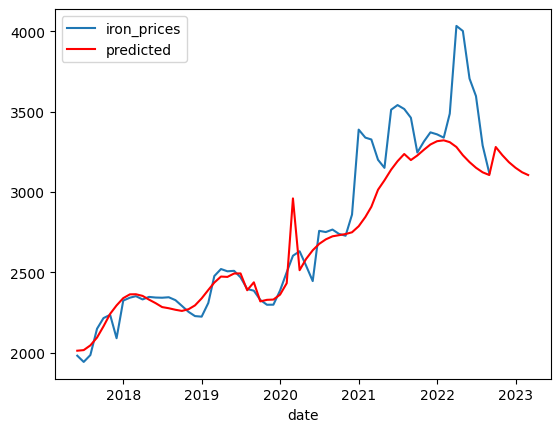

In [75]:
res['date']= res.index
res.columns[-1]
df= res

ax = plt.gca()
df.plot(kind='line',x=res.columns[-1],y='iron_prices',ax=ax)
df.plot(kind='line',x=res.columns[-1],y='predicted', color='red', ax=ax)


plt.show()

In [99]:
res.to_csv(r'C:\Users\fnafisa\WORKSPACE\Project PoC\output\predictions.csv', encoding='utf-8', index=False)
